In [1]:
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
import json
from nltk.tokenize import word_tokenize
import re
from collections import Counter
from nltk.corpus import stopwords
import string
import pandas as pd
import pytz
import vincent
import random
vincent.core.initialize_notebook()
%matplotlib inline

# Define Helper Methods

## Text Processing Methods
methods and regular expressions for doing tweet preprocessing

In [2]:
#regex to filter out emoticons
emoticons_str = r"""
    (?:
        [:=;] 
        [oO\-]? 
        [D\)\]\(\]/\\OpP] 
    )"""
 
#regex to filter bad strings    
regex_str = [
    emoticons_str,
    r'<[^>]+>', # HTML tags
    r'(?:@[\w_]+)', # @-mentions
    r"(?:\#+[\w_]+[\w\'_\-]*[\w_]+)", # hash-tags
    r'http[s]?://(?:[a-z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-f][0-9a-f]))+', # URLs
 
    r'(?:(?:\d+,?)+(?:\.?\d+)?)', # numbers
    r"(?:[a-z][a-z'\-_]+[a-z])", # words with - and '
    r'(?:[\w_]+)', # other words
    r'(?:\S)' # anything else
]

#use re to compile the regex
tokens_re = re.compile(r'('+'|'.join(regex_str)+')', re.VERBOSE | re.IGNORECASE)
emoticon_re = re.compile(r'^'+emoticons_str+'$', re.VERBOSE | re.IGNORECASE)
   
def tokenize(s):
    """
    Tokenizes a string
    -Parameter s: The string to tokenize
    -Return: The tokenized string
    """
    return tokens_re.findall(s)
 
def preprocess(s, lowercase=False):
    """
    Preprocesses string by tokenizing and applying the emoticon and string regex
    Parameter s: The string to preprocess
    Return: The list of the processed tokens
    """
    tokens = tokenize(s)
    if lowercase:
        tokens = [token if emoticon_re.search(token) else token.lower() for token in tokens]
    return tokens

## Map Helper Methods
Methods to aid in the mapping of tweets using leaflet.js

In [3]:
def to_json(data_array):
    """
    Converts an array of tweets into a json file that can be used by leaflet.js to create a map and
    saves the json file to the directory using the name geo_data.json. Note that this quietly overwrites
    the current data_array so be careful using it
    -Parameter data_array: The array to be converted
    """
    #initialize geo_data json (just a dict here) to feed in to the maps
    geo_data = {
        "type": "FeatureCollection",
        "features": []
    }

    #populate the json file
    for d in data_array:
        geo_json_feature = {
                "type": "Feature",
                "geometry": {"type" : "Point", "coordinates" : d['coordinates']},
                "properties": {
                    "text": d['text'],
                    "created_at": d['created_at']
                }
            }
        geo_data['features'].append(geo_json_feature)

    #write the json out to a file
    with open('geo_data.json', 'w') as fout:
        fout.write(json.dumps(geo_data, indent=4))

## Vector Helper Methods
methods for doing useful computations using vectors in python list form

In [4]:
#Note vectors here are denoted by normal python lists

def vector_add(v,w):
    """
    Perform a vector addition with two vectors
    -Parameter v: The first vector to add
    -Parameter w: The second vector to add
    -Return: The two vectors added together elementwise 
    ex. [0,2] + [1,1] = [1,3]
    """
    return[v_i + w_i for v_i, w_i in zip(v,w)]

def vector_sum(vectors):
    """
    Perform a vector sum with an array of vectors
    -Parameter vectors: A list holding the vectors to be added
    -Return: The list of vectors added together 
    ex. [0,2] + [1,1] + [2,2] = [3,5]
    """
    result = vectors[0]
    for vector in vectors[1:]:
        result = vector_add(result, vector)
    return result

def vector_subtract(v, w):
    """
    Perform a vector subtraction with two vectors as v-w
    -Parameter v: The vector to be subtracted from
    -Parameter w: The vector to subtract
    -Return: The two vectors subtracted elementwise 
    ex. [1,3] - [1,1] = [0,2]
    """
    return [v_i - w_i for v_i, w_i in zip(v,w)]

def scalar_multiply(c, v):
    """
    Preform a scalar multiplication on vector v by constant c
    -Paramter c: The constant to be multiplied by
    -Paramter v: The vector to be scalar multiplied
    -Return The vector scalar multiplied by c
    ex. 3 * [1,2] = [3,6]
    """
    return[c * v_i for v_i in v]

def vector_mean(vectors):
    """
    Compute a component wise mean for a list of vectors
    -Parameter vectors: The list of vectors to be averaged
    -Return a vector whose elements are the componentwise means of the vectors in the vector list
    ex. vector_mean([[0,1], [1,1]]) = [0.5,1]
    """
    n = len(vectors)
    return scalar_multiply(1/n, vector_sum(vectors))

def dot(v, w):
    """
    Compute v dot w. Note order does not matter because v dot w = w dot v for all vectors
    -Parameter v: a vector to be dotted
    -Parameter w: the second vector to be dotted
    -Return v dot w
    ex. [1,1] dot [2,2] = 4
    """
    return sum(v_i * w_i for v_i, w_i in zip(v,w))

def sum_of_squares(v):
    """
    Returns the sum of squares for a given vector. Note this is just v dot v
    -Parameter v: The vector to be summed
    -Return the sum of squares of vector v. Can be sqrted to get vector length
    ex. sum_of_squares([2,2]) = 8
    """
    return dot(v,v)

def squared_distance(v,w):
    """
    Computes the squared distance between two vectors. Note this is just the sum of squares of v-w
    -Parameter v: The first vector
    -Parameter w: The second vector
    -Return The squared distance between two vectors. Can be sqrted to get vector distance
    ex. sum_of_squares([2,2],[1,1]) = 2
    """
    return sum_of_squares(vector_subtract(v,w))

In [ ]:
class KMeans(object):
    """performs k-means clustering"""

    def __init__(self, k):
        """
        Init the KMeans object
        -Parameter k: the number of clusters to find
        """
        self.k = k          # number of clusters
        self.means = None   # means of clusters

    def classify(self, input_vector):
        """
        Return the index of the cluster closest to the input
        -Parameter input_vector: the vector to be classified
        -Return the cluster closest to the input_vector
        """
        return min(range(self.k),
                   key=lambda i: squared_distance(input_vector, self.means[i]))

    def train(self, inputs):
        """
        Train the k means object on a given input of vector arrays. Finds K means of clusters in the data
        -Parameter inputs: The list of vectors to be trained on
        """
        
        #randomly pick the means to start out with
        self.means = random.sample(inputs, self.k)
        assignments = None

        while True:
            # Find new assignments
            new_assignments = list(map(self.classify, inputs))

            # If no assignments have changed, then we have convergence and are done
            if assignments == new_assignments:
                return

            # Otherwise keep the new assignments,
            assignments = new_assignments

            for i in range(self.k):
                i_points = [p for p, a in zip(inputs, assignments) if a == i]
                # avoid divide-by-zero if i_points is empty
                if i_points:
                    self.means[i] = vector_mean(i_points)


## Data Analysis and Filtration Helper Methods
Methods to help with analysis and filtration of the data
Note the bounding boxes are specified in the following form:
[left_lower_lat, left_lower_long, right_upper_lat, right_upper_long]

coordinates are in WSG84

In [5]:
def plot_bar(datums):
    """
    Plots a bar graph of the passed list of tuples ordered (name, score)
    -Parameter datums: The list of tuples to be plotted
    """
    datums.sort(key=lambda x: x[1], reverse=True) 
    hashtag = list(zip(*datums))[0]
    score = list(zip(*datums))[1]
    x_pos = np.arange(len(hashtag)) 
    plt.figure(figsize=(20, 10))
    plt.bar(x_pos, score,align='center')
    plt.xticks(x_pos, hashtag) 
    plt.ylabel('Score')
    

In [6]:
def filter_geo(d_array, loc):
    """
    Filters a given array of tweets to only include tweets within a the given bounding box.
    -Parameter d_array: The array of tweets to be filtered
    -Parameter loc: The bounding box to be filtered
    -Return: A list containing the filtered tweets
    """
    geo_array = []
    for dd in d_array:
        if(checkBox(dd,loc)):
            #append the data point to the data array
            geo_array.append(dd)
    return geo_array
    

In [32]:
def count_terms(d_array):
    punctuation = list(string.punctuation)
    stop = stopwords.words('english') + punctuation + ['via', 'I\'m', 'I', '😂', 'like','get','don\'t']

    count = Counter()
    for d in d_array:
    #     tokens = preprocess(d['text'])
    #     terms_stop = [term for term in preprocess(d['text']) if term not in stop]
        terms_hash = [term for term in preprocess(d['text']) if term.startswith('#')]
        count.update(terms_hash)
        del count['#']
    return count

In [39]:
def rand_sample(n):
    rand_smpl = [ data_array[i] for i in sorted(random.sample(range(len(data_array)), n))]
    return rand_smpl
    

In [7]:
#Bounding Boxes of the most populous cities in the US and a few others to get a better spread
nyc = [-74,40,-73,41]
san_fran = [-122.75,36.8,-121.75,37.8]
la = [-118.668176,33.703692,-118.155289,34.337306]
chicago = [-87.940267,41.644335,-87.524044,42.023131]
houston = [-95.788087,29.523624,-95.014496,30.110732]
philadelphia = [-75.280303,39.871514,-74.955763,40.137992]
phoenix = [-112.324056,33.29026,-111.926046,33.92057]
san_antonio = [-98.805851,29.224141,-98.222958,29.73872]
san_diego = [-117.282167,32.534856,-116.90816,33.114249]
dallas = [-96.998941,32.617537,-96.463738,33.023792]
san_jose = [-122.045668,37.124493,-121.589154,37.469538]
seattle = [-122.435908,47.495551,-122.235903,47.734145]
denver = [-105.109927,39.614431,-104.600296,39.914247]
nashville = [-87.054903,35.967785,-86.515588,36.405496]

In [8]:
def checkBox(d, box):
    """
    Checks if a given tweet is inside a bounding box
    -Parameter d: The tweet to be checked
    -Parameter box: The bounding box to be checked
    -Return: True if the tweet is inside the box. False if it is outside
    """
    x = d['coordinates'][0]
    y = d['coordinates'][1]
    if(x < box[0]): 
        return False
    if(y < box[1]): 
        return False
    if(x >= box[2]): 
        return False
    if(y >= box[3]): 
        return False
    return True

In [9]:
#we filter these hashtags because they seem to dominate everywhere and are not very useful tweets to look at because
#they are just advertisements
bad_hashtags = ['#Hiring','#job','#Job','#Jobs','#CareerArc']

# Start of Data Analysis
This is where we start actually analyzing the data

## Unpickle The Tweet File 
We start by unpickling the tweet file, filtering out tweets with no hashtags or with blacklisted hashtags, then storing the tweet in an array.

In [10]:
f = open('/Users/calvin/Documents/Lehigh/English/Research/data/cap3.pkl', 'rb')
data_array = []
geo_data = []
count = 0
x_sum = 0
y_sum = 0

while True:
    try:
        dd = pkl.load(f)
    except EOFError:
        break
    except Exception:
        print(count)
        count += 1
        unpickler.load()
        continue
    else:
        #right now we just take the first coordinate in the bounding box as the actual
        #we could average to find the middle, but this seems good enough for now
        if dd['coordinates'] == None:
            if dd['place'] == None:
                continue
            dd['coordinates'] = dd['place']['bounding_box']['coordinates'][0][0]
        else:
            #account for edge case where coordinates are wrapped
            dd['coordinates'] = dd['coordinates']['coordinates']
        
        #filter out all tweets with no hashtags and take out word related hashtags because those are unhelpful
        #TODO- we can keep more data if we can do a sentiment analysis on the tweets instead of just filtering
        if '#' in dd['text'] and (not any(hashtag in dd['text'] for hashtag in bad_hashtags)):
            data_array.append(dd)

## Filter Tweets by Geo Location
Apply location based filtering to the preprocessed dataset and randomly sample the preprocessed data set.

In [17]:
nyc_geo_data = filter_geo(data_array, nyc)
sf_geo_data = filter_geo(data_array, san_fran)

In [40]:
n = 10000
#create a random sample of size n form the data_array
rand_smpl = rand_sample(n)

## Find Most Common Hashtags in our Data and Graph Them Using Histograms

In [42]:
count_sf = count_terms(sf_geo_data)
count_nyc = count_terms(nyc_geo_data)
count_rand = count_terms(rand_smpl)

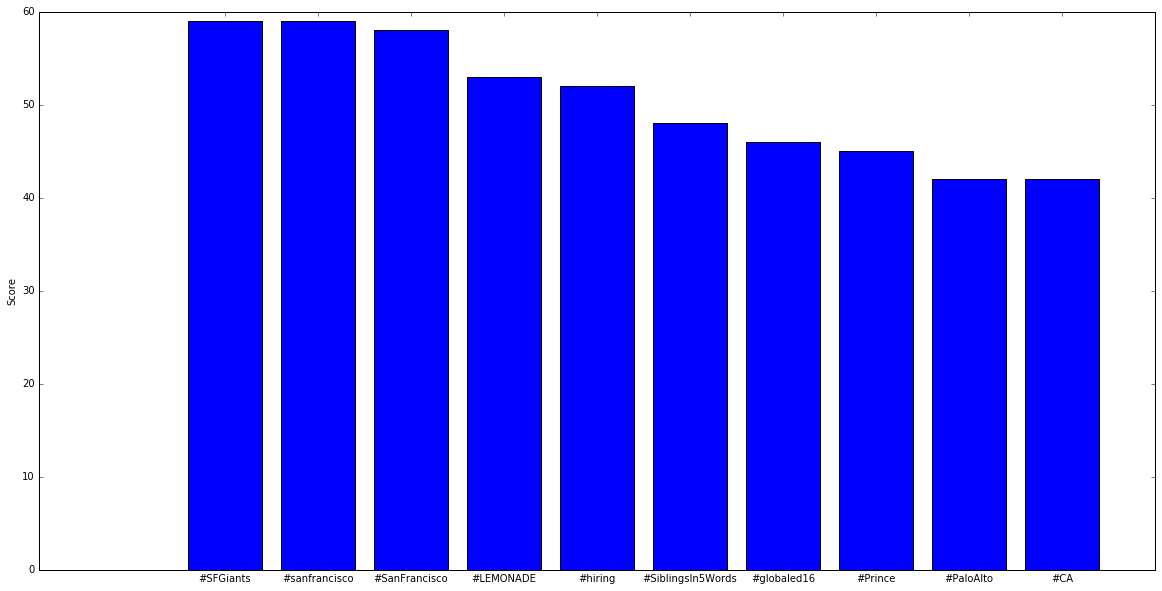

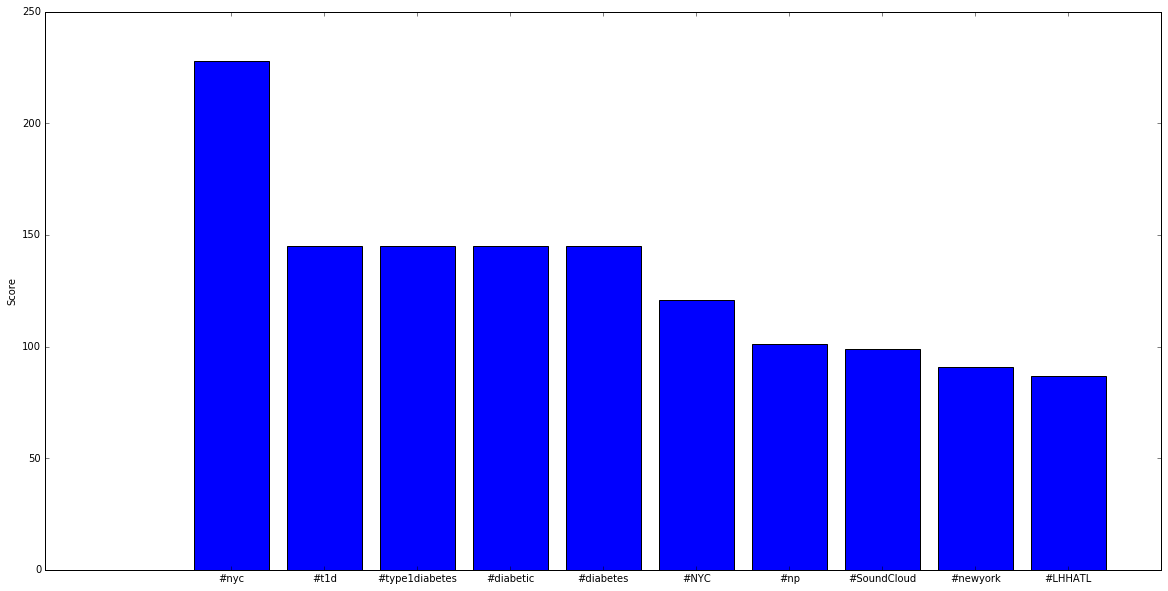

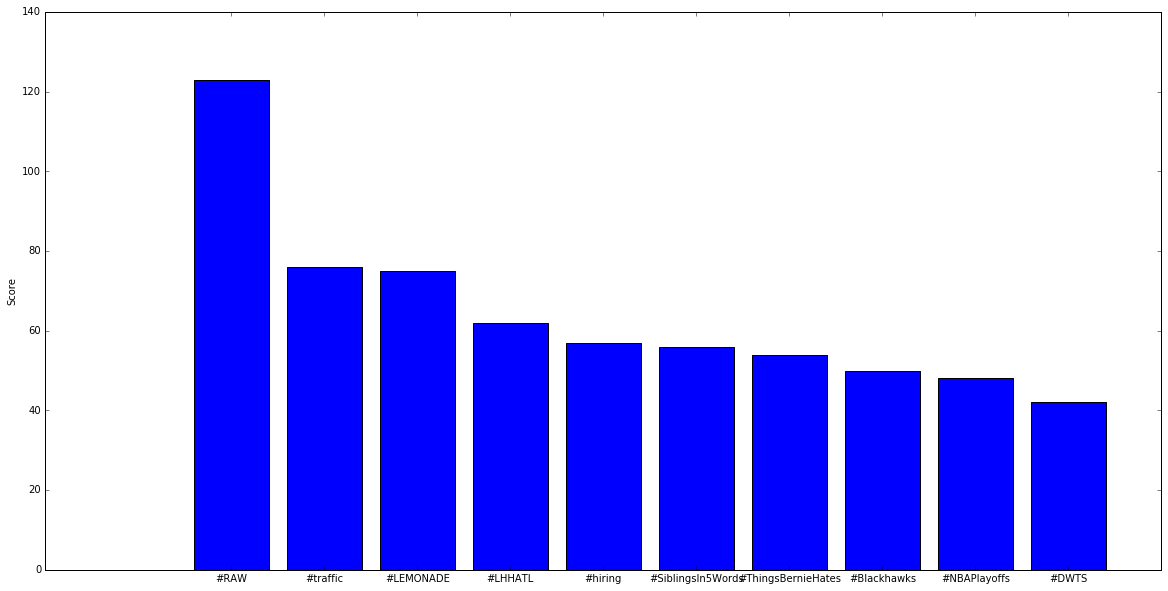

In [43]:
plot_bar(count_sf.most_common(10))
plot_bar(count_nyc.most_common(10))
plot_bar(count_rand.most_common(10))

In [ ]:
filtered = []
for d in data_array:
    if "#RAW" in d['text']:
#     if checkBox(d,san_fran):
        filtered.append(d)

In [ ]:
print(filtered[100]['text'])

In [ ]:
to_json(filtered)

In [ ]:
dates = []
eastern = pytz.timezone('US/Eastern')
for d in filtered:
    dates.append(d['created_at'])
ones = [1]*len(dates)
idx = pd.DatetimeIndex(dates).tz_localize(pytz.utc).tz_convert(eastern)
dates_series = pd.Series(ones, index=idx)
# Resampling / bucketing
per_minuite = dates_series.resample('1Min', how='sum').fillna(0)


In [ ]:
time_chart = vincent.Line(per_minuite)
time_chart.axis_titles(x='Time', y='Freq')